In [1]:
# Copyright (c) 2015-2016, the authors (see AUTHORS.txt).
# Licensed under the BSD 3-clause license (see LICENSE.txt)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import unittest
import deepgp
import GPy
import os
import h5py
import tables

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy

base_path = os.path.dirname("__file__")

<IPython.core.display.Javascript object>


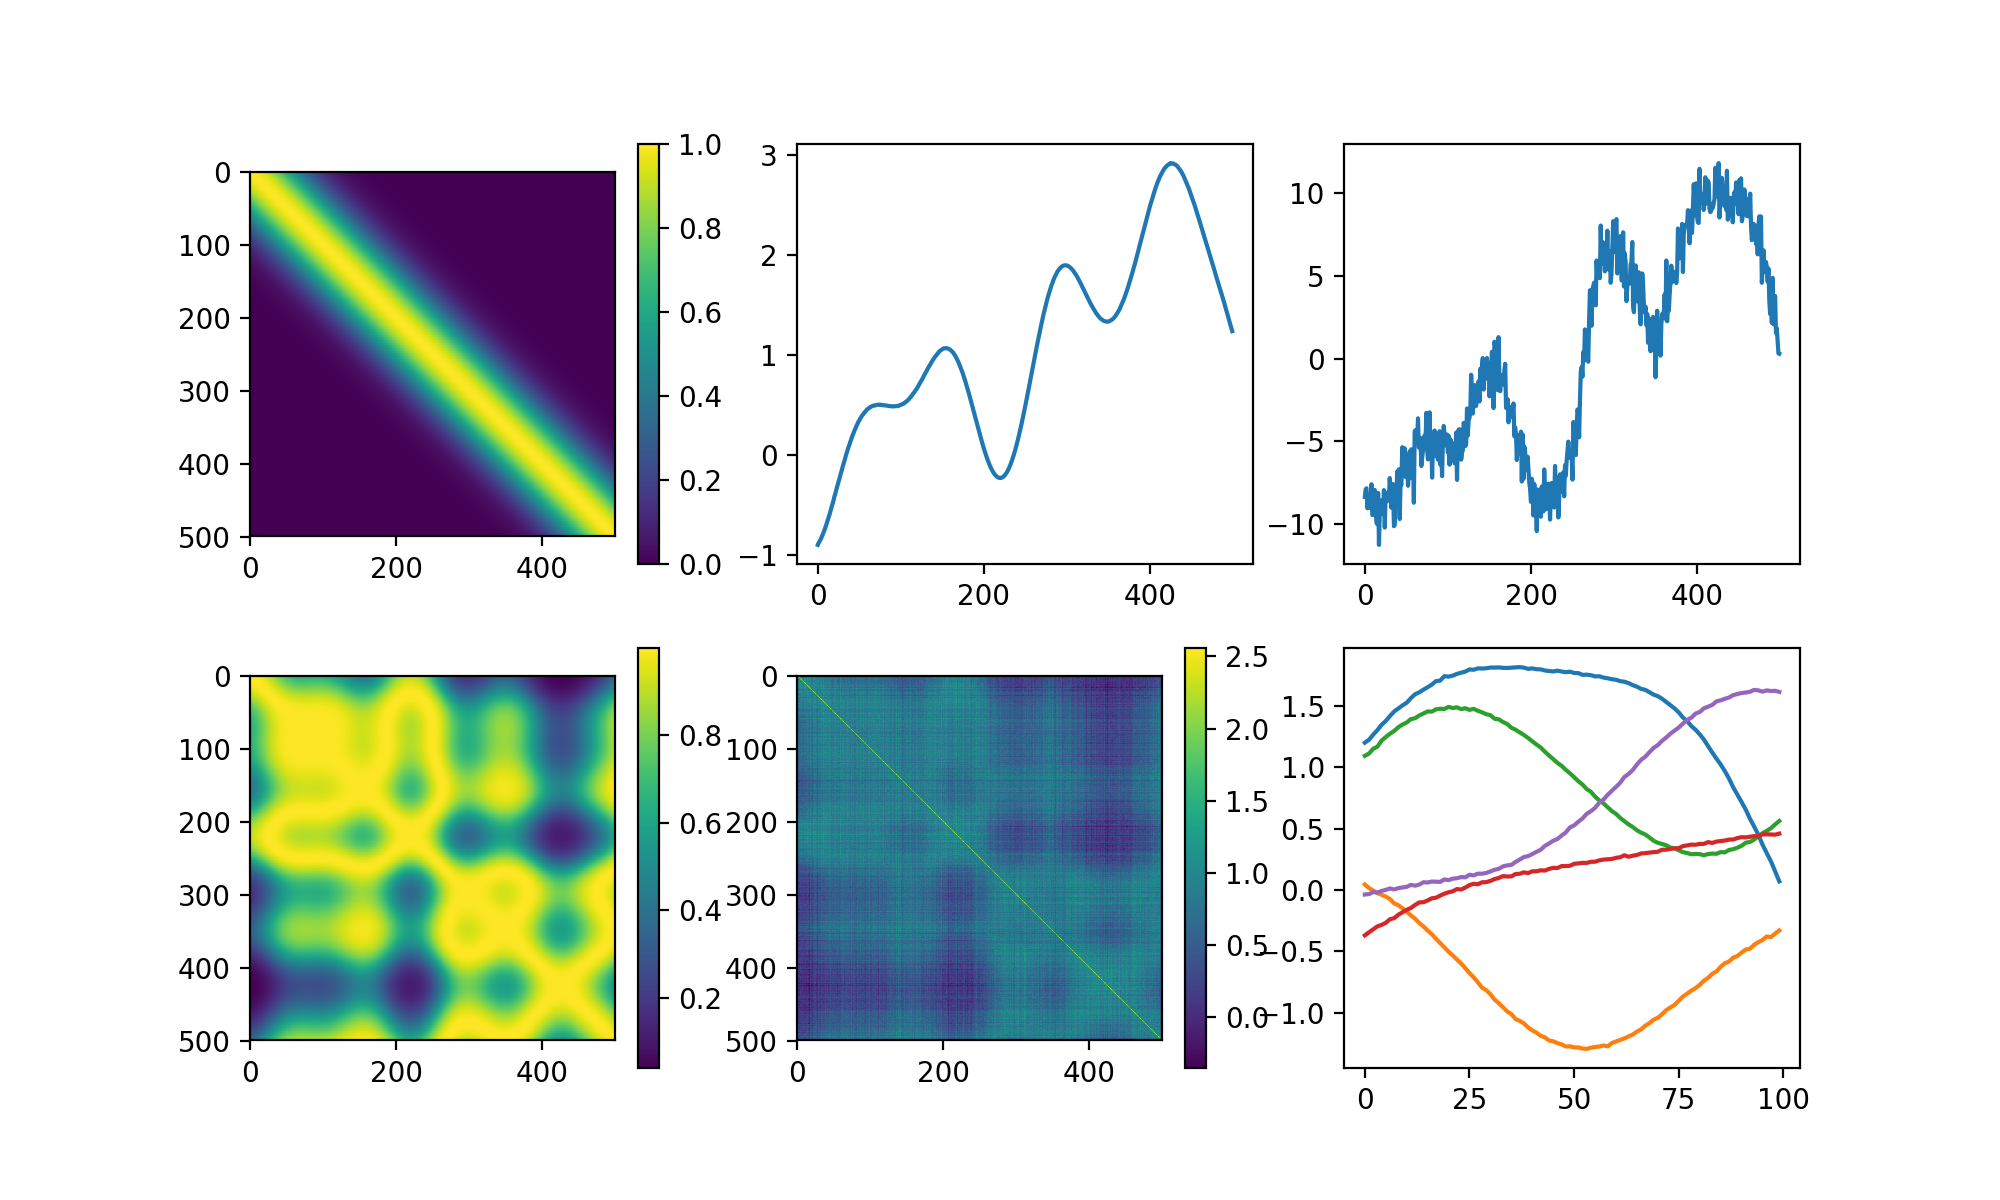

 /Users/anqiwu/anaconda/envs/vae-tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/anqiwu/anaconda/envs/vae-tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning:covariance is not positive-semidefinite.


Number of data points N=500
Number of features D=200
Number of latent dimensions K=1


In [7]:
def const(x):
    x = tf.constant(x,dtype=tf.float32)
    return x

plt.subplots(2,3,figsize=(10,6))

def build_toy_dataset(N, D, K, Ngrid = 100, prior_l=1, prior_sig_f=1, l=1.5, sig_f=1, sig_n=1):
    Nall = Ngrid + N
    tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)

    sess = ed.get_session()
    with sess.as_default():
        Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

    z_mu = np.zeros(N)
    z_cov = Kprior + 1e-10*np.eye(N)
    z = np.random.multivariate_normal(z_mu, z_cov).T.reshape(-1,1)
    zgrid = np.linspace(z.min(), z.max(), num=Ngrid).reshape(-1,1)
    zall = np.vstack((z,zgrid))

    plt.subplot(2,3,1)
    plt.imshow(Kprior)
    plt.colorbar()
    plt.subplot(2,3,2)
    plt.plot(z)

    with sess.as_default():
        Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

    Kz = Kzall[:N,:N]
    xall = np.random.multivariate_normal(np.zeros(Nall), Kzall, D).T
    x = xall[:N,:]
    xgrid = xall[N:,:]
    noise = np.random.randn(x.shape[0],x.shape[1])
    x = x + sig_n*noise

    plt.subplot(2,3,4)
    plt.imshow(Kz)
    plt.colorbar()
    plt.subplot(2,3,5)
    plt.imshow(np.cov(x))
    plt.colorbar()
    plt.subplot(2,3,6)
    plt.plot(xgrid[:,:5])

    return x,xgrid,z,zgrid,tgrid,Kz,Kprior

N = 500  # number of data points, number of time points
D = 200  # data dimensionality, number of neurons
K = 1  # latent dimensionality

x_true, xgrid, z_true, zgrid, tgrid, Kz_true, Kprior_true = build_toy_dataset(N, D, K)

print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

# visualize the covariance of Z
plt.subplot(2,3,3)
plt.plot(z_init)

scipy.io.savemat('syn.mat',mdict={'x_true':x_true, 'xgrid':xgrid, 'z_true':z_true, 'zgrid':zgrid, 
                                  'tgrid':tgrid, 'Kz_true':Kz_true, 'Kprior_true':Kprior_true})